In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [9]:
import argparse
import os
from collections import defaultdict

import torch

from habitat.config import Config as CN
from habitat.utils.visualizations.utils import images_to_video, observations_to_image

from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class, NavRLEnv
from habitat_baselines.config.default import get_config
from habitat_baselines.utils.common import batch_obs, generate_video
from habitat_baselines.utils.env_utils import construct_envs

from my_habitat_baselines.resnet_policy import PointNavResNetPolicy

In [10]:
jupyter_dir = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter"

jupyter_dir

'/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter'

In [11]:
#
# specify args
#

model_path = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models"

arg_string = ""

arg_string += "--model-path %s" % model_path

arg_string += \
"""
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000
"""

print(arg_string)

parser = argparse.ArgumentParser()
parser.add_argument("--model-path", type=str, required=True)
parser.add_argument("--sensors", type=str, required=True)
parser.add_argument("--hidden-size", type=int, required=True)
parser.add_argument(
    "--normalize-visual-inputs", type=int, required=True, choices=[0, 1]
)
parser.add_argument(
    "--backbone",
    type=str,
    required=True,
    choices=["resnet50", "se_resneXt50"],
)
parser.add_argument("--num-recurrent-layers", type=int, required=True)
parser.add_argument(
    "opts",
    default=None,
    nargs=argparse.REMAINDER,
    help="Modify config options from command line",
)
args = parser.parse_args(arg_string.split())

print(args)

--model-path /Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000

Namespace(backbone='resnet50', hidden_size=512, model_path='/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models', normalize_visual_inputs=1, num_re

In [225]:
#
# load and customize config
#

habitat_dir = "/Users/mroberts/code/github/habitat-lab"
os.chdir(habitat_dir)

config = get_config(
    "habitat_baselines/config/pointnav/ppo_pointnav.yaml"
)

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL = CN()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = None
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = None
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV = None
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV = None
config.TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY = None
config.freeze()

config.merge_from_list(args.opts)

config.defrost()
# config.TASK_CONFIG.SIMULATOR.ACTION_SPACE_CONFIG = "pyrobotnoisy"
config.freeze()

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.ROBOT = "LoCoBot"
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = "ILQR"    # our pre-trained model lists "proportional" in the filename, so don't change to ILQR 
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 1.0 # our pre-trained model lists "0.5" in the filename, so don't change to 1.0
config.freeze()

config.defrost()
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ["*"]
config.TASK_CONFIG.DATASET.DATA_PATH = "data/datasets/pointnav/gibson/v1/train/train.json.gz" # don't have obstacle_1 scenes, so use Gibson instead
config.freeze()

config.defrost()
config.NUM_ENVIRONMENTS = 1
config.freeze()

config.defrost()
if args.sensors == "":
    config.SENSORS = []
else:
    config.SENSORS = args.sensors.split(",")
# TODO(akadian): collisions are not working
# config.TASK_CONFIG.TASK.MEASUREMENTS.append("COLLISIONS")
config.freeze()

print(config)

BASE_TASK_CONFIG_PATH: configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: -1
CMD_TRAILING_OPTS: []
ENV_NAME: NavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
FORCE_BLIND_POLICY: False
FORCE_TORCH_SINGLE_THREADED: True
LOG_FILE: train.log
LOG_INTERVAL: 25
NUM_CHECKPOINTS: 100
NUM_ENVIRONMENTS: 1
NUM_PROCESSES: -1
NUM_UPDATES: 10000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
PROFILING:
  CAPTURE_START_STEP: -1
  NUM_STEPS_TO_CAPT

In [16]:
#
# construct a single env instead of multiple envs for simplicity
#

env = NavRLEnv(config)

2021-11-09 13:44:39,986 Initializing dataset PointNav-v1
2021-11-09 13:46:51,201 initializing sim Sim-v0
I1109 13:46:51.212056 159706560 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1109 13:46:55.322259 37944 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Roeville.navmesh
I1109 13:46:51.213212 159706560 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1109 13:46:51.220129 159706560 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1109 13:46:51.221901 159706560 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


In [17]:
#
# create device
#

device = (
    torch.device("cuda:{}".format(config.TORCH_GPU_ID))
    if torch.cuda.is_available()
    else torch.device("cpu")
)

device

device(type='cpu')

In [227]:
#
# load model
#

def load_model(
    path,
    observation_space,
    action_space,
    hidden_size,
    normalize_visual_inputs,
    backbone,
    num_recurrent_layers,
    device,
):

    model = PointNavResNetPolicy(
        observation_space=observation_space,
        action_space=action_space,
        hidden_size=hidden_size,
        normalize_visual_inputs=normalize_visual_inputs,
        backbone=backbone,
        num_recurrent_layers=num_recurrent_layers,
        goal_sensor_uuid="pointgoal_with_gps_compass",
    )

    model.to(device)

    new_model_params = sum(
        [torch.numel(p) for _, p in model.named_parameters()]
    )

    saved_model = torch.load(path, map_location=device)
    saved_model_params = sum(
        [torch.numel(v) for k, v in saved_model["state_dict"].items()]
    )

    print(
        "new_model_params: {}, saved_model_params: {}".format(
            new_model_params, saved_model_params
        )
    )

    saved_model_state_dict = {}
    for k, v in saved_model["state_dict"].items():
        new_k = k.replace("actor_critic.", "")
        saved_model_state_dict[new_k] = v

    model.load_state_dict(saved_model_state_dict)

    return model



model_path = \
"/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/" + \
"job_19633792"                        + "." \
"sensor_RGB_SENSOR"                   + "." \
"train_data_gibson"                   + "." \
"noise_multiplier_0.5"                + "." \
"noise_model_controller_Proportional" + "." \
"agent_radius_0.20"                   + "." \
"success_reward_10.0"                 + "." \
"slack_reward_-0.01"                  + "." \
"collision_reward_0.0"                + "." \
"spl_max_collisions_500"              + "_" \
"ckpt.000000049"                      + \
".pth"
print(model_path)

action_space = env.action_space
observation_space = env.observation_space

model = load_model(
    path=model_path,
    observation_space=observation_space,
    action_space=action_space,
    hidden_size=args.hidden_size,
    normalize_visual_inputs=bool(args.normalize_visual_inputs),
    backbone=args.backbone,
    num_recurrent_layers=args.num_recurrent_layers,
    device=device,
)

model.eval()

model_params = 0
for k,v in model.state_dict().items():
    # print(k, torch.numel(v))
    model_params += torch.numel(v)
print(model_params)

saved_model = torch.load(model_path, map_location=device)

saved_model_params = 0
for k,v in saved_model["state_dict"].items():
    # print(k, torch.numel(v))
    saved_model_params += torch.numel(v)
print(saved_model_params)

/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/job_19633792.sensor_RGB_SENSOR.train_data_gibson.noise_multiplier_0.5.noise_model_controller_Proportional.agent_radius_0.20.success_reward_10.0.slack_reward_-0.01.collision_reward_0.0.spl_max_collisions_500_ckpt.000000049.pth
new_model_params: 12458053, saved_model_params: 12458060
12458060
12458060


In [ ]:
#
# load other scene besides data/scene_datasets/gibson/Roeville.glb as a sanity check
#

for i in range(100000):
    if i % 1000 == 0:
        print(i)
    observation = env.reset()
    if env.current_episode.scene_id != "data/scene_datasets/gibson/Roeville.glb":
        print("break")
        break

print(env.current_episode.scene_id)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.


I1109 18:42:51.058877 159706560 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1109 18:42:51.061269 159706560 SemanticScene.h:43] Deconstructing SemanticScene
I1109 18:42:51.061278 159706560 SceneManager.h:25] Deconstructing SceneManager
I1109 18:42:51.061282 159706560 SceneGraph.h:25] Deconstructing SceneGraph
I1109 18:42:51.061762 159706560 Sensor.cpp:69] Deconstructing Sensor
I1109 18:42:51.107832 159706560 Renderer.cpp:71] Deconstructing Renderer
I1109 18:42:51.110321 159706560 WindowlessContext.h:17] Deconstructing WindowlessContext
I1109 18:42:51.120270 159706560 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Dunmor.glb and dataset : default which is currently active dataset.
I1109 18:42:51.231568 159706560 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Dunmor.glb changed to proposed scene_instance.json filename : data/scene_d

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify
break
data/scene_datasets/gibson/Dunmor.glb


lator.cpp:374] ::createSceneInstance : Start to load stage named : data/scene_datasets/gibson/Dunmor.glb with render asset : data/scene_datasets/gibson/Dunmor.glb and collision asset : data/scene_datasets/gibson/Dunmor.glb
I1109 18:42:51.236816 159706560 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1109 18:42:51.236821 159706560 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Dunmor.glb.
I1109 18:42:51.236824 159706560 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Dunmor.glb 
I1109 18:42:51.236838 159706560 ResourceManager.cpp:1281] Importing Basis files as BC3 for Dunmor.glb
I1109 18:42:55.172343 159706560 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/gibson/Dunmor.glb
W1109 18:42:55.172359 159706560 Simulator.cpp:427] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I110

DISTANCE_TO_GOAL
DISTANCE_TO: POINT
TYPE: DistanceToGoal
<class 'habitat.tasks.nav.nav.DistanceToGoal'>
distance_to_goal

NavigationEpisode(episode_id='39910', scene_id='data/scene_datasets/gibson/Dunmor.glb', start_position=[6.340555191040039, 0.021137923002243042, 2.4199745655059814], start_rotation=[0, 0.30881770127284763, 0, -0.9511212474656184], info={'geodesic_distance': 4.477910041809082, 'difficulty': 'easy'}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7f9dc9376d30>, goals=[NavigationGoal(position=[5.047633171081543, 0.021137923002243042, 5.901503086090088], radius=None)], start_room=None, shortest_paths=None)

{'distance_to_goal': 4.6812310218811035, 'success': 0.0, 'spl': 0.0}

tensor([[0.]])


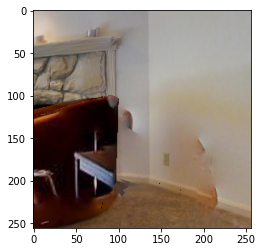

In [986]:
#
# initialization before main loop
#

metric_name = config.TASK_CONFIG.TASK.MEASUREMENTS[0]
metric_cfg = getattr(config.TASK_CONFIG.TASK, metric_name)
measure_type = baseline_registry.get_measure(metric_cfg.TYPE)
metric_uuid = measure_type(None, None)._get_uuid()

assert measure_type is not None, "invalid measurement type {}".format(metric_cfg.TYPE)

print(metric_name)
print(metric_cfg)
print(measure_type)
print(metric_uuid)
print()

observation = env.reset()

print(env.current_episode)
print()

print(env._env.get_metrics())
print()

observations = [observation]
batch = batch_obs(observations, device)

num_envs = 1
num_processes = 1

current_episode_reward = 0.0

test_recurrent_hidden_states = torch.zeros(
    model.net.num_recurrent_layers,
    num_processes,
    args.hidden_size,
    device=device,
)
prev_actions = torch.zeros(
    num_processes, 1, device=device, dtype=torch.long
)
not_done_masks = torch.zeros(num_processes, 1, device=device)
print(not_done_masks)

stats_episodes = dict()  # dict of dicts that stores stats per episode

stats_actions = defaultdict(int)

rgb_frames = [
    [] for _ in range(num_processes)
]

figsize(4,4)
imshow(observation["rgb"]);

STOP
defaultdict(<class 'int'>, {3: 8, 1: 23, 2: 7, 0: 1})

2.49
True
{'distance_to_goal': 0.1191004291176796, 'success': 1.0, 'spl': 0.8110915312996895}

tensor([[0.]])

Episodes finished: 1
{('data/scene_datasets/gibson/Dunmor.glb', '39910'): {'distance_to_goal': 0.1191004291176796, 'success': 1.0, 'spl': 0.8110915312996895, 'reward': 6.672130592763427}}



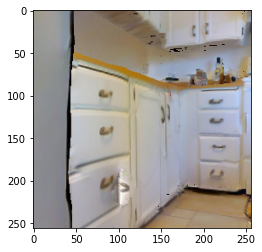

In [1025]:
#
# main loop: choose action
#

# current_episodes = [env.current_episode]
# print(current_episodes)

# print(batch)
# print(test_recurrent_hidden_states)
# print(prev_actions)
# print(not_done_masks)

with torch.no_grad():
    _, actions, _, test_recurrent_hidden_states = model.act(
        batch,
        test_recurrent_hidden_states,
        prev_actions,
        not_done_masks,
        deterministic=False,
    )

    prev_actions.copy_(actions)

assert len(actions) == 1
action = actions[0]

print(env.habitat_env.task.get_action_name(action.item()))
stats_actions[action.item()] += 1

print(stats_actions)
print()



#
# main loop: perform action
#

observation, reward, done, info = env.step(action=action.item())
# observation, reward, done, info = env.step(action="TURN_RIGHT")
# observation, reward, done, info = env.step(action="MOVE_FORWARD")
# observation, reward, done, info = env.step(action="STOP")

print(reward)
print(done)
print(info)
print()

imshow(observation["rgb"]);



#
# main loop: update state
#

observations = [observation]
batch = batch_obs(observations, device)

dones = [done]
not_done_masks = torch.tensor(
    [[0.0] if done else [1.0] for done in dones],
    dtype=torch.float,
    device=device,
)

print(not_done_masks)
print()

current_episode_reward += reward

# next_episodes = [env.current_episode]
# envs_to_pause = []

# i = 0
# if (env.current_episode.scene_id, env.current_episode.episode_id) in stats_episodes:
#     envs_to_pause.append(i)

# episode ended
if done:
    # episode_stats = dict()
    # episode_stats[metric_uuid] = info[metric_uuid]
    # episode_stats["success"] = int(info[metric_uuid] > 0)
    # episode_stats["reward"] = current_episode_reward

    episode_stats = dict(info)
    episode_stats["reward"] = current_episode_reward
    
    current_episode_reward = 0.0
                 
    # use scene_id and episode_id as unique id for storing stats
    stats_episodes[ (env.current_episode.scene_id, env.current_episode.episode_id) ] = episode_stats

    print("Episodes finished: {}".format(len(stats_episodes)))
    print(stats_episodes)
    print()